In [1]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 128,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39597,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:36909,Total threads: 8
Dashboard: http://127.0.0.1:42241/status,Memory: 62.93 GiB
Nanny: tcp://127.0.0.1:39657,


In [2]:
import xarray as xr
profile_path = '/data/shared_data/Interp_Profiles/regional/TP/TAO/TAO_WO_2012_ADCP.nc'
ds_adcp = xr.open_dataset(profile_path)
profile_path = '/data/shared_data/Interp_Profiles/regional/TP/TAO/TAO_WO_2012_CUR.nc'
ds_cur = xr.open_dataset(profile_path)
# these are hourly profiles

In [3]:
import pandas as pd
# Combine date and time into a datetime array
dates = ds_adcp['prof_YYYYMMDD'].values.astype(int)
times = ds_adcp['prof_HHMMSS'].values.astype(int)

# Convert to zero-padded strings
date_strs = dates.astype(str)
time_strs = times.astype(str)
time_strs = [t.zfill(6) for t in time_strs]  # ensure time is like 'HHMMSS'
# Combine into full datetime strings and convert to pandas datetime
datetime_strs = [d + t for d, t in zip(date_strs, time_strs)]
datetimes = pd.to_datetime(datetime_strs, format='%Y%m%d%H%M%S')

# Assign as coordinate and optionally swap dimensions
ds_adcp = ds_adcp.assign_coords(time=('iPROF', datetimes))
# ds_adcp = ds_adcp.swap_dims({'iPROF': 'time'})
ds_adcp = ds_adcp.assign_coords(depth=('iDEPTH', ds_adcp['prof_depth'].values*-1))
# ds_adcp = ds_adcp.swap_dims({'iDEPTH': 'depth'})
ds_adcp = ds_adcp.assign_coords(lat=('iPROF', ds_adcp['prof_lat'].values))
ds_adcp = ds_adcp.assign_coords(lon=('iPROF', ds_adcp['prof_lon'].values))
# ds_adcp.set_index(lat='lat', lon='lon')
# Combine date and time into a datetime array
dates = ds_cur['prof_YYYYMMDD'].values.astype(int)
times = ds_cur['prof_HHMMSS'].values.astype(int)

# Convert to zero-padded strings
date_strs = dates.astype(str)
time_strs = times.astype(str)
time_strs = [t.zfill(6) for t in time_strs]  # ensure time is like 'HHMMSS'
# Combine into full datetime strings and convert to pandas datetime
datetime_strs = [d + t for d, t in zip(date_strs, time_strs)]
datetimes = pd.to_datetime(datetime_strs, format='%Y%m%d%H%M%S')

# Assign as coordinate and optionally swap dimensions
ds_cur = ds_cur.assign_coords(time=('iPROF', datetimes))
# ds_cur = ds_cur.swap_dims({'iPROF': 'time'})
ds_cur = ds_cur.assign_coords(depth=('iDEPTH', ds_cur['prof_depth'].values*-1))
# ds_cur = ds_cur.swap_dims({'iDEPTH': 'depth'})
ds_cur = ds_cur.assign_coords(lat=('iPROF', ds_cur['prof_lat'].values))
ds_cur = ds_cur.assign_coords(lon=('iPROF', ds_cur['prof_lon'].values))
# ds_cur.set_index(lat='lat', lon='lon')

In [4]:
adcp_by_lon = ds_adcp.groupby('lon')
cur_by_lon = ds_cur.groupby('lon')


In [5]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.colors import TwoSlopeNorm
import cmocean.cm as cmo
warnings.filterwarnings("ignore")
plt.rcParams['font.size'] = 13
from xmitgcm import open_mdsdataset
data_dir = '/data/SO3/edavenport/tpose6/sep2012/run_iter0/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = ['diag_state']
ds = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200)
ds['XC'] = ds.XC.astype(float)
ds['YC'] = ds.YC.astype(float)
ds['Z'] = ds.Z.astype(float)
ds['XG'] = ds.XG.astype(float)
ds['YG'] = ds.YG.astype(float)

In [6]:
U6_140 = ds.UVEL.interp(XG=[220.0],YC=[0.0],Z=adcp_by_lon[220.0].depth.values,time=adcp_by_lon[220.0].time.values,method='linear')

U6_TAO_140 = U6_140.copy(deep=True)
U6_TAO_140.values = adcp_by_lon[220.0].prof_U.values[:,:,np.newaxis,np.newaxis]
U6_TAO_140.name = 'U6_TAO_140'
U6_TAO_140 = U6_TAO_140.where(U6_TAO_140 != -9999.0)

U6_110 = ds.UVEL.interp(XG=[250.0],YC=[0.0],Z=adcp_by_lon[250.0].depth.values,time=adcp_by_lon[250.0].time.values,method='linear')

U6_TAO_110 = U6_140.copy(deep=True)
U6_TAO_110.values = adcp_by_lon[250.0].prof_U.values[:,:,np.newaxis,np.newaxis]
U6_TAO_110.name = 'U6_TAO_110'
U6_TAO_110 = U6_TAO_110.where(U6_TAO_110 != -9999.0)

U6_170 = ds.UVEL.interp(XG=[190.0],YC=[0.0],Z=adcp_by_lon[190.0].depth.values,time=adcp_by_lon[190.0].time.values,method='linear')

U6_TAO_170 = U6_170.copy(deep=True)
U6_TAO_170.values = adcp_by_lon[190.0].prof_U.values[:,:,np.newaxis,np.newaxis]
U6_TAO_170.name = 'U6_TAO_170'
U6_TAO_170 = U6_TAO_170.where(U6_TAO_170 != -9999.0)

U6_165E = ds.UVEL.interp(XG=[165.0],YC=[0.0],Z=adcp_by_lon[165.0].depth.values,time=adcp_by_lon[165.0].time.values,method='linear')

U6_TAO_165E = U6_165E.copy(deep=True)
U6_TAO_165E.values = adcp_by_lon[165.0].prof_U.values[:,:,np.newaxis,np.newaxis]
U6_TAO_165E.name = 'U6_TAO_165E'
U6_TAO_165E = U6_TAO_165E.where(U6_TAO_165E != -9999.0)

# -------------------------

V6_140 = ds.VVEL.interp(XC=[220.0],YG=[0.0],Z=adcp_by_lon[220.0].depth.values,time=adcp_by_lon[220.0].time.values,method='linear')

V6_TAO_140 = V6_140.copy(deep=True)
V6_TAO_140.values = adcp_by_lon[220.0].prof_V.values[:,:,np.newaxis,np.newaxis]
V6_TAO_140.name = 'V6_TAO_140'
V6_TAO_140 = V6_TAO_140.where(V6_TAO_140 != -9999.0)

V6_110 = ds.VVEL.interp(XC=[250.0],YG=[0.0],Z=adcp_by_lon[250.0].depth.values,time=adcp_by_lon[250.0].time.values,method='linear')

V6_TAO_110 = V6_140.copy(deep=True)
V6_TAO_110.values = adcp_by_lon[250.0].prof_V.values[:,:,np.newaxis,np.newaxis]
V6_TAO_110.name = 'V6_TAO_110'
V6_TAO_110 = V6_TAO_110.where(V6_TAO_110 != -9999.0)

V6_170 = ds.VVEL.interp(XC=[190.0],YG=[0.0],Z=adcp_by_lon[190.0].depth.values,time=adcp_by_lon[190.0].time.values,method='linear')

V6_TAO_170 = V6_170.copy(deep=True)
V6_TAO_170.values = adcp_by_lon[190.0].prof_V.values[:,:,np.newaxis,np.newaxis]
V6_TAO_170.name = 'V6_TAO_170'
V6_TAO_170 = V6_TAO_170.where(V6_TAO_170 != -9999.0)

V6_165E = ds.VVEL.interp(XC=[165.0],YG=[0.0],Z=adcp_by_lon[165.0].depth.values,time=adcp_by_lon[165.0].time.values,method='linear')

V6_TAO_165E = V6_165E.copy(deep=True)
V6_TAO_165E.values = adcp_by_lon[165.0].prof_V.values[:,:,np.newaxis,np.newaxis]
V6_TAO_165E.name = 'V6_TAO_165E'
V6_TAO_165E = V6_TAO_165E.where(V6_TAO_165E != -9999.0)

In [7]:
from scipy.signal import detrend, butter, sosfiltfilt
U6_TAO_140 = U6_TAO_140.sel(time=slice('2012-09-01', None))
V6_TAO_140 = V6_TAO_140.sel(time=slice('2012-09-01', None))
U6_140 = U6_140.sel(time=slice('2012-09-01', None))
V6_140 = V6_140.sel(time=slice('2012-09-01', None))

U6_TAO_110 = U6_TAO_110.sel(time=slice('2012-09-01', None))
V6_TAO_110 = V6_TAO_110.sel(time=slice('2012-09-01', None))
U6_110 = U6_110.sel(time=slice('2012-09-01', None))
V6_110 = V6_110.sel(time=slice('2012-09-01', None))

U6_TAO_170 = U6_TAO_170.sel(time=slice('2012-09-01', None))
V6_TAO_170 = V6_TAO_170.sel(time=slice('2012-09-01', None))
U6_170 = U6_170.sel(time=slice('2012-09-01', None))
V6_170 = V6_170.sel(time=slice('2012-09-01', None))

depths = U6_TAO_140.Z.values

zMax = -35
zMin = -250
Udepthli = np.argmin(np.abs(depths - zMax))
Udepthui = np.argmin(np.abs(depths - zMin)) + 1

# crop the time series to the depths we are interested in and the first two years (after that there are some large gaps in TAO data)
U6_140 = U6_140[3:,Udepthli:Udepthui,0,0]
U6_TAO_140 = U6_TAO_140[3:,Udepthli:Udepthui,0,0]
U6_TAO_140 = U6_TAO_140.where(~np.isnan(U6_TAO_140),0.0)
U6_140 = U6_140.where(~np.isnan(U6_140),0.0)

V6_140 = V6_140[3:,Udepthli:Udepthui,0,0]
V6_TAO_140 = V6_TAO_140[3:,Udepthli:Udepthui,0,0]
V6_TAO_140 = V6_TAO_140.where(~np.isnan(V6_TAO_140),0.0)
V6_140 = V6_140.where(~np.isnan(V6_140),0.0)

U6_110 = U6_110[3:,Udepthli:Udepthui,0,0]
U6_TAO_110 = U6_TAO_110[3:,Udepthli:Udepthui,0,0]
U6_TAO_110 = U6_TAO_110.where(~np.isnan(U6_TAO_110),0.0)
U6_110 = U6_110.where(~np.isnan(U6_110),0.0)

V6_110 = V6_110[3:,Udepthli:Udepthui,0,0]
V6_TAO_110 = V6_TAO_110[3:,Udepthli:Udepthui,0,0]
V6_TAO_110 = V6_TAO_110.where(~np.isnan(V6_TAO_110),0.0)
V6_110 = V6_110.where(~np.isnan(V6_110),0.0)

U6_170 = U6_170[3:,Udepthli:Udepthui,0,0]
U6_TAO_170 = U6_TAO_170[3:,Udepthli:Udepthui,0,0]
U6_TAO_170 = U6_TAO_170.where(~np.isnan(U6_TAO_170),0.0)
U6_170 = U6_170.where(~np.isnan(U6_170),0.0)

V6_170 = V6_170[3:,Udepthli:Udepthui,0,0]
V6_TAO_170 = V6_TAO_170[3:,Udepthli:Udepthui,0,0]
V6_TAO_170 = V6_TAO_170.where(~np.isnan(V6_TAO_170),0.0)
V6_170 = V6_170.where(~np.isnan(V6_170),0.0)


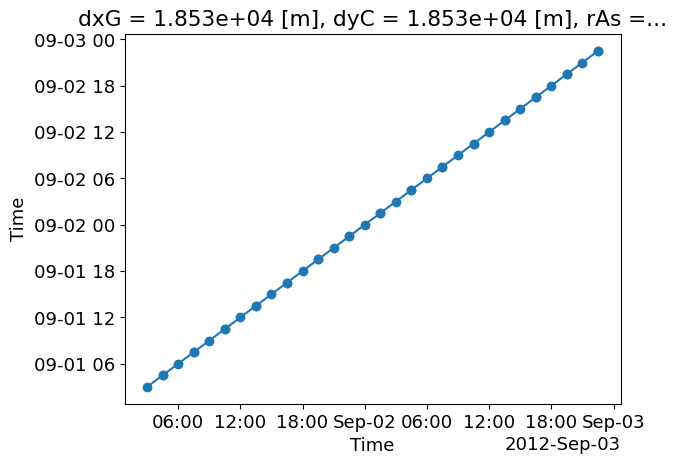

In [82]:
V6_140.sel(time=slice('2012-09-01', '2012-09-02')).time.plot(marker='o')

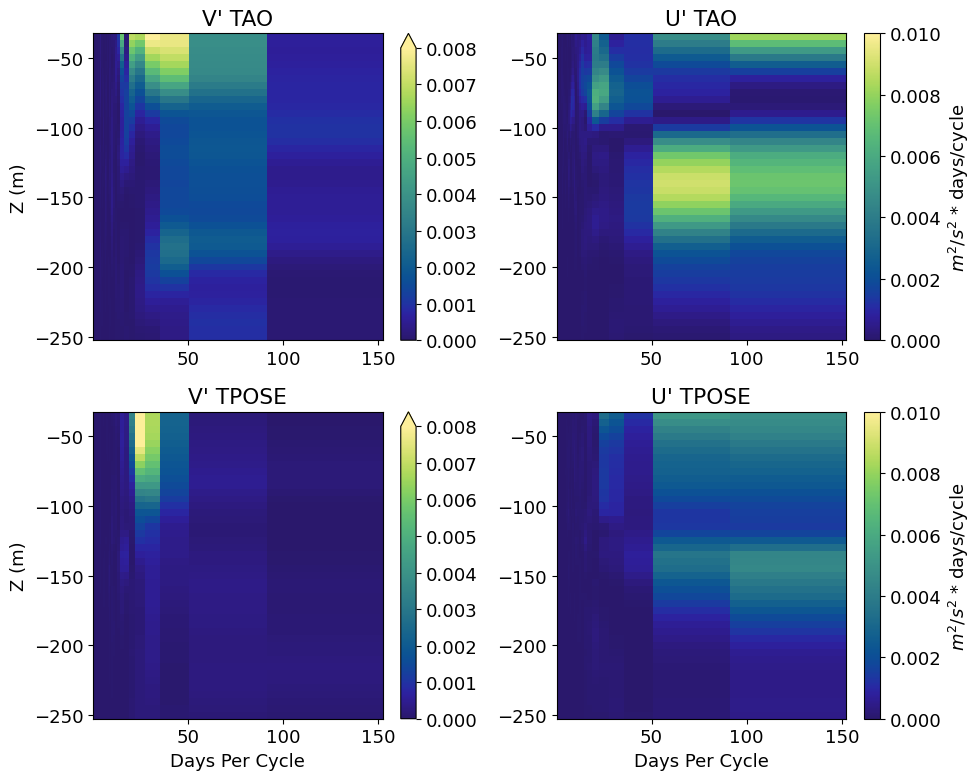

In [8]:
# get Vprime
V_detrend = detrend(V6_TAO_140.values,axis=0,type='linear') 
V_anom = V_detrend - np.nanmean(V_detrend,axis=0)

# filter each *time series* which is each row (rows are depth)
Vprime_filt = V_anom

N = len(V6_TAO_140.time)

# get Uprime 
U_detrend = detrend(U6_TAO_140,axis=0,type='linear') 
U_anom = U_detrend - np.nanmean(U_detrend,axis=0)
Uprime_filt = U_anom

# get Vprime TPOSE 
V_TP_detrend = detrend(V6_140,axis=0,type='linear') 
V_TP_anom = V_TP_detrend - np.nanmean(V_TP_detrend,axis=0)
Vprime_TP_filt = V_TP_anom

# get Uprime TPOSE
U_TP_detrend = detrend(U6_140,axis=0,type='linear') 
U_TP_anom = U_TP_detrend - np.nanmean(U_TP_detrend,axis=0)
Uprime_TP_filt = U_TP_anom

window = np.hanning(N)*np.ones([len(U6_TAO_140.Z),1])
Vp_windowed = Vprime_filt*window.T

Fsst = np.fft.fft(Vp_windowed,axis=0)
vprime_tao_filt = abs(Fsst[:N//2+1,:]**2)
vprime_tao_filt[1:-2,:] = 2*vprime_tao_filt[1:-2,:]
vprime_tao_filt[1:] = vprime_tao_filt[1:]/N**2

freq_segments = 1/(np.arange(N//2 + 1)/N) # profiles per cycle
freq_segments = freq_segments/24 # convert to days/cycle (hourly profiles)

Up_windowed = Uprime_filt*window.T
Fsst = np.fft.fft(Up_windowed,axis=0)
uprime_tao_filt = abs(Fsst[:N//2+1,:]**2)
uprime_tao_filt[1:-2,:] = 2*uprime_tao_filt[1:-2,:]
uprime_tao_filt[1:] = uprime_tao_filt[1:]/N**2

Vp_TP_windowed = Vprime_TP_filt*window.T
Fsst = np.fft.fft(Vp_TP_windowed,axis=0)
vprime_tpose_filt = abs(Fsst[:N//2+1,:]**2)
vprime_tpose_filt[1:-2,:] = 2*vprime_tpose_filt[1:-2,:]
vprime_tpose_filt[1:] = vprime_tpose_filt[1:]/N**2

Up_TP_windowed = Uprime_TP_filt*window.T
Fsst = np.fft.fft(Up_TP_windowed,axis=0)
uprime_tpose_filt = abs(Fsst[:N//2+1,:]**2)
uprime_tpose_filt[1:-2,:] = 2*uprime_tpose_filt[1:-2,:]
uprime_tpose_filt[1:] = uprime_tpose_filt[1:]/N**2

label_str = r'$m^2/s^2$ * days/cycle'


temp = V6_TAO_140[:len(freq_segments)-1].copy(deep=True)
temp.values = vprime_tao_filt[1:,:]
vprime_tao_filt = temp
vprime_tao_filt['time'] = freq_segments[1:]

temp = V6_TAO_140[:len(freq_segments)-1].copy(deep=True)
temp.values = uprime_tao_filt[1:,:]
uprime_tao_filt = temp
uprime_tao_filt['time'] = freq_segments[1:]

temp = V6_TAO_140[:len(freq_segments)-1].copy(deep=True)
temp.values = vprime_tpose_filt[1:,:]
vprime_tpose_filt = temp
vprime_tpose_filt['time'] = freq_segments[1:]

temp = V6_TAO_140[:len(freq_segments)-1].copy(deep=True)
temp.values = uprime_tpose_filt[1:,:]
uprime_tpose_filt = temp
uprime_tpose_filt['time'] = freq_segments[1:]

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,8))
vprime_tao_filt.plot(x='time',y='Z',ax=ax[0,0],cmap=cmo.haline,vmin=0,vmax=0.8e-2,cbar_kwargs={'label':''})
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Z (m)')
# ax[0].semilogx()
# ax[0,0].set_xlim(5,80)
ax[0,0].set_title('V\' TAO')

uprime_tao_filt.plot(x='time',y='Z',ax=ax[0,1],cmap=cmo.haline,vmin=0.0,vmax=1.0e-2,cbar_kwargs={'label':label_str})
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')
# ax[1].semilogx()
# ax[0,1].set_xlim(5,80)
ax[0,1].set_title('U\' TAO')

vprime_tpose_filt.plot(x='time',y='Z',ax=ax[1,0],cmap=cmo.haline,vmin=0,vmax=0.8e-2,cbar_kwargs={'label':''})
ax[1,0].set_xlabel('Days Per Cycle')
ax[1,0].set_ylabel('Z (m)')
# ax[0].semilogx()
# ax[1,0].set_xlim(5,80)
ax[1,0].set_title('V\' TPOSE')

uprime_tpose_filt.plot(x='time',y='Z',ax=ax[1,1],cmap=cmo.haline,vmin=0.0,vmax=1.0e-2,cbar_kwargs={'label':label_str})
ax[1,1].set_xlabel('Days Per Cycle')
ax[1,1].set_ylabel('')
# ax[1].semilogx()
# ax[1,1].set_xlim(5,80)
ax[1,1].set_title('U\' TPOSE')

plt.tight_layout()
plt.savefig('V_U_power_spectrogram_TAO_TPOSE_iter0_140W.png',format='png')

v_tpose_total_140 = vprime_tpose_filt.sum()
v_tao_total_140 = vprime_tao_filt.sum()
v_ratio_140 = v_tpose_total_140/v_tao_total_140
vprime_tao_filt_140 = vprime_tao_filt
vprime_tpose_filt_140 = vprime_tpose_filt

u_tpose_total_140 = uprime_tpose_filt.sum()
u_tao_total_140 = uprime_tao_filt.sum()
u_ratio_140 = u_tpose_total_140/u_tao_total_140
uprime_tao_filt_140 = uprime_tao_filt
uprime_tpose_filt_140 = uprime_tpose_filt




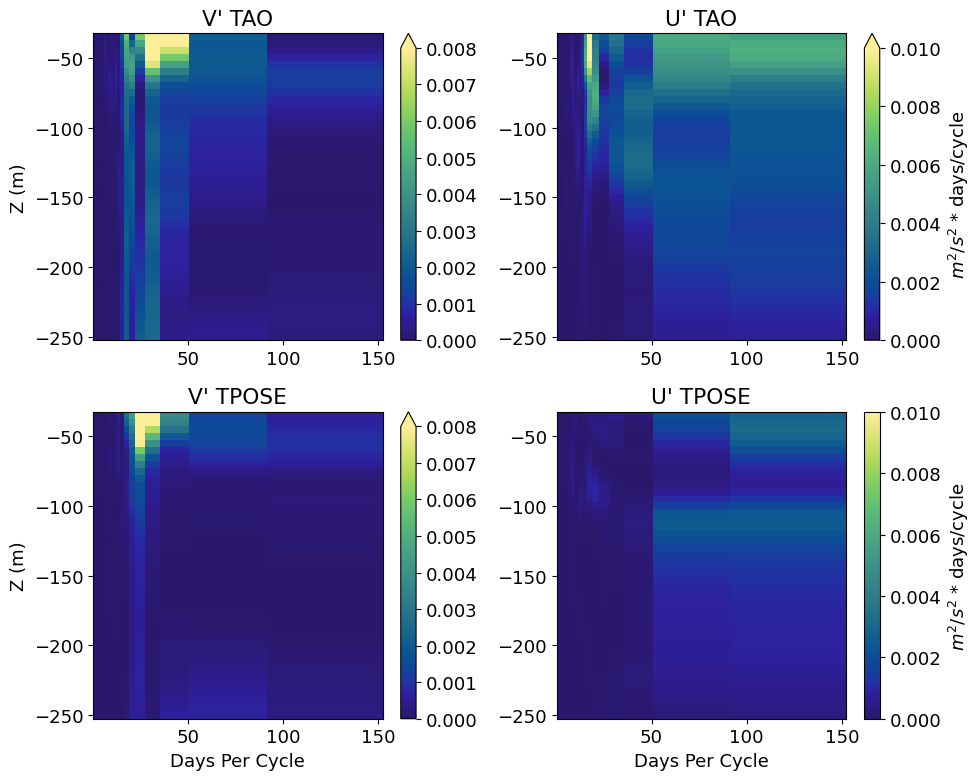

In [10]:
# get Vprime
V_detrend = detrend(V6_TAO_110.values,axis=0,type='linear') 
V_anom = V_detrend - np.nanmean(V_detrend,axis=0)

# filter each *time series* which is each row (rows are depth)
Vprime_filt = V_anom

N = len(V6_TAO_110.time)

# get Uprime 
U_detrend = detrend(U6_TAO_110,axis=0,type='linear') 
U_anom = U_detrend - np.nanmean(U_detrend,axis=0)
Uprime_filt = U_anom

# get Vprime TPOSE 
V_TP_detrend = detrend(V6_110,axis=0,type='linear') 
V_TP_anom = V_TP_detrend - np.nanmean(V_TP_detrend,axis=0)
Vprime_TP_filt = V_TP_anom

# get Uprime TPOSE
U_TP_detrend = detrend(U6_110,axis=0,type='linear') 
U_TP_anom = U_TP_detrend - np.nanmean(U_TP_detrend,axis=0)
Uprime_TP_filt = U_TP_anom

window = np.hanning(N)*np.ones([len(U6_TAO_110.Z),1])
Vp_windowed = Vprime_filt*window.T

Fsst = np.fft.fft(Vp_windowed,axis=0)
vprime_tao_filt = abs(Fsst[:N//2+1,:]**2)
vprime_tao_filt[1:-2,:] = 2*vprime_tao_filt[1:-2,:]
vprime_tao_filt[1:] = vprime_tao_filt[1:]/N**2

freq_segments = 1/(np.arange(N//2 + 1)/N) # profiles per cycle
freq_segments = freq_segments/24 # convert to days/cycle (hourly profiles)

Up_windowed = Uprime_filt*window.T
Fsst = np.fft.fft(Up_windowed,axis=0)
uprime_tao_filt = abs(Fsst[:N//2+1,:]**2)
uprime_tao_filt[1:-2,:] = 2*uprime_tao_filt[1:-2,:]
uprime_tao_filt[1:] = uprime_tao_filt[1:]/N**2

Vp_TP_windowed = Vprime_TP_filt*window.T
Fsst = np.fft.fft(Vp_TP_windowed,axis=0)
vprime_tpose_filt = abs(Fsst[:N//2+1,:]**2)
vprime_tpose_filt[1:-2,:] = 2*vprime_tpose_filt[1:-2,:]
vprime_tpose_filt[1:] = vprime_tpose_filt[1:]/N**2

Up_TP_windowed = Uprime_TP_filt*window.T
Fsst = np.fft.fft(Up_TP_windowed,axis=0)
uprime_tpose_filt = abs(Fsst[:N//2+1,:]**2)
uprime_tpose_filt[1:-2,:] = 2*uprime_tpose_filt[1:-2,:]
uprime_tpose_filt[1:] = uprime_tpose_filt[1:]/N**2

label_str = r'$m^2/s^2$ * days/cycle'


temp = V6_TAO_110[:len(freq_segments)-1].copy(deep=True)
temp.values = vprime_tao_filt[1:,:]
vprime_tao_filt = temp
vprime_tao_filt['time'] = freq_segments[1:]

temp = V6_TAO_110[:len(freq_segments)-1].copy(deep=True)
temp.values = uprime_tao_filt[1:,:]
uprime_tao_filt = temp
uprime_tao_filt['time'] = freq_segments[1:]

temp = V6_TAO_110[:len(freq_segments)-1].copy(deep=True)
temp.values = vprime_tpose_filt[1:,:]
vprime_tpose_filt = temp
vprime_tpose_filt['time'] = freq_segments[1:]

temp = V6_TAO_110[:len(freq_segments)-1].copy(deep=True)
temp.values = uprime_tpose_filt[1:,:]
uprime_tpose_filt = temp
uprime_tpose_filt['time'] = freq_segments[1:]

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,8))
vprime_tao_filt.plot(x='time',y='Z',ax=ax[0,0],cmap=cmo.haline,vmin=0,vmax=0.8e-2,cbar_kwargs={'label':''})
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Z (m)')
# ax[0].semilogx()
# ax[0,0].set_xlim(5,80)
ax[0,0].set_title('V\' TAO')

uprime_tao_filt.plot(x='time',y='Z',ax=ax[0,1],cmap=cmo.haline,vmin=0.0,vmax=1.0e-2,cbar_kwargs={'label':label_str})
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')
# ax[1].semilogx()
# ax[0,1].set_xlim(5,80)
ax[0,1].set_title('U\' TAO')

vprime_tpose_filt.plot(x='time',y='Z',ax=ax[1,0],cmap=cmo.haline,vmin=0,vmax=0.8e-2,cbar_kwargs={'label':''})
ax[1,0].set_xlabel('Days Per Cycle')
ax[1,0].set_ylabel('Z (m)')
# ax[0].semilogx()
# ax[1,0].set_xlim(5,80)
ax[1,0].set_title('V\' TPOSE')

uprime_tpose_filt.plot(x='time',y='Z',ax=ax[1,1],cmap=cmo.haline,vmin=0.0,vmax=1.0e-2,cbar_kwargs={'label':label_str})
ax[1,1].set_xlabel('Days Per Cycle')
ax[1,1].set_ylabel('')
# ax[1].semilogx()
# ax[1,1].set_xlim(5,80)
ax[1,1].set_title('U\' TPOSE')

plt.tight_layout()
plt.savefig('V_U_power_spectrogram_TAO_TPOSE_iter0_110W.png',format='png')

v_tpose_total_110 = vprime_tpose_filt.sum()
v_tao_total_110 = vprime_tao_filt.sum()
v_ratio_110 = v_tpose_total_110/v_tao_total_110
vprime_tao_filt_110 = vprime_tao_filt
vprime_tpose_filt_110 = vprime_tpose_filt

u_tpose_total_110 = uprime_tpose_filt.sum()
u_tao_total_110 = uprime_tao_filt.sum()
u_ratio_110 = u_tpose_total_110/u_tao_total_110
uprime_tao_filt_110 = uprime_tao_filt
uprime_tpose_filt_110 = uprime_tpose_filt

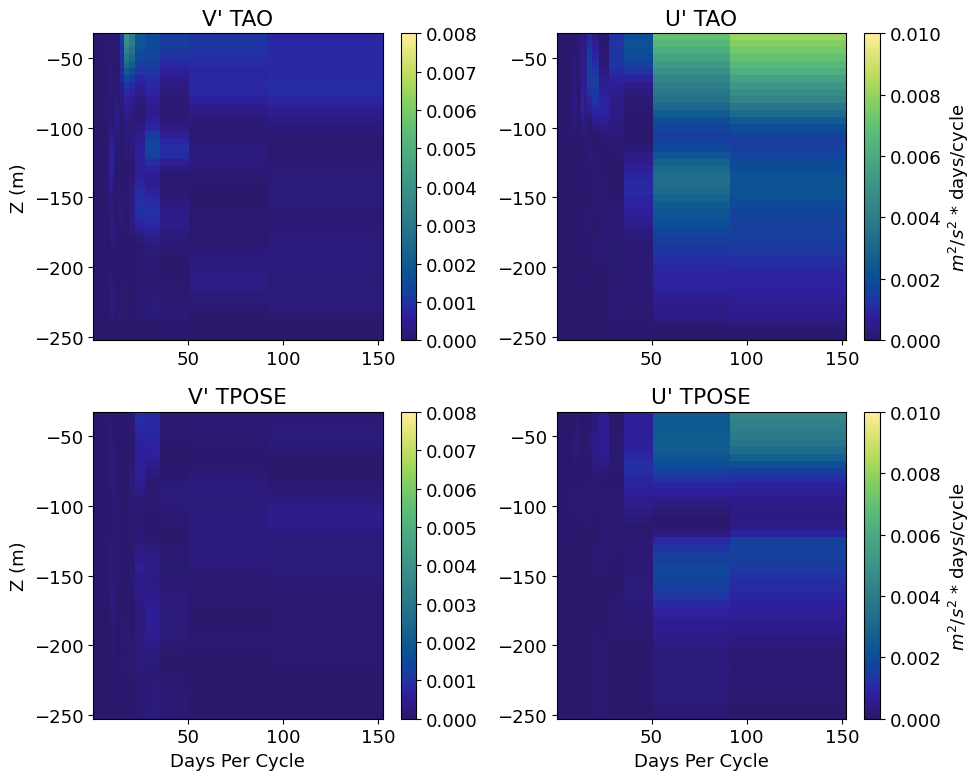

In [11]:
# get Vprime
V_detrend = detrend(V6_TAO_170.values,axis=0,type='linear') 
V_anom = V_detrend - np.nanmean(V_detrend,axis=0)

# filter each *time series* which is each row (rows are depth)
Vprime_filt = V_anom

N = len(V6_TAO_170.time)

# get Uprime 
U_detrend = detrend(U6_TAO_170,axis=0,type='linear') 
U_anom = U_detrend - np.nanmean(U_detrend,axis=0)
Uprime_filt = U_anom

# get Vprime TPOSE 
V_TP_detrend = detrend(V6_170,axis=0,type='linear') 
V_TP_anom = V_TP_detrend - np.nanmean(V_TP_detrend,axis=0)
Vprime_TP_filt = V_TP_anom

# get Uprime TPOSE
U_TP_detrend = detrend(U6_170,axis=0,type='linear') 
U_TP_anom = U_TP_detrend - np.nanmean(U_TP_detrend,axis=0)
Uprime_TP_filt = U_TP_anom

window = np.hanning(N)*np.ones([len(U6_TAO_170.Z),1])
Vp_windowed = Vprime_filt*window.T

Fsst = np.fft.fft(Vp_windowed,axis=0)
vprime_tao_filt = abs(Fsst[:N//2+1,:]**2)
vprime_tao_filt[1:-2,:] = 2*vprime_tao_filt[1:-2,:]
vprime_tao_filt[1:] = vprime_tao_filt[1:]/N**2

freq_segments = 1/(np.arange(N//2 + 1)/N) # profiles per cycle
freq_segments = freq_segments/24 # convert to days/cycle (hourly profiles)

Up_windowed = Uprime_filt*window.T
Fsst = np.fft.fft(Up_windowed,axis=0)
uprime_tao_filt = abs(Fsst[:N//2+1,:]**2)
uprime_tao_filt[1:-2,:] = 2*uprime_tao_filt[1:-2,:]
uprime_tao_filt[1:] = uprime_tao_filt[1:]/N**2

Vp_TP_windowed = Vprime_TP_filt*window.T
Fsst = np.fft.fft(Vp_TP_windowed,axis=0)
vprime_tpose_filt = abs(Fsst[:N//2+1,:]**2)
vprime_tpose_filt[1:-2,:] = 2*vprime_tpose_filt[1:-2,:]
vprime_tpose_filt[1:] = vprime_tpose_filt[1:]/N**2

Up_TP_windowed = Uprime_TP_filt*window.T
Fsst = np.fft.fft(Up_TP_windowed,axis=0)
uprime_tpose_filt = abs(Fsst[:N//2+1,:]**2)
uprime_tpose_filt[1:-2,:] = 2*uprime_tpose_filt[1:-2,:]
uprime_tpose_filt[1:] = uprime_tpose_filt[1:]/N**2

label_str = r'$m^2/s^2$ * days/cycle'


temp = V6_TAO_170[:len(freq_segments)-1].copy(deep=True)
temp.values = vprime_tao_filt[1:,:]
vprime_tao_filt = temp
vprime_tao_filt['time'] = freq_segments[1:]

temp = V6_TAO_170[:len(freq_segments)-1].copy(deep=True)
temp.values = uprime_tao_filt[1:,:]
uprime_tao_filt = temp
uprime_tao_filt['time'] = freq_segments[1:]

temp = V6_TAO_170[:len(freq_segments)-1].copy(deep=True)
temp.values = vprime_tpose_filt[1:,:]
vprime_tpose_filt = temp
vprime_tpose_filt['time'] = freq_segments[1:]

temp = V6_TAO_170[:len(freq_segments)-1].copy(deep=True)
temp.values = uprime_tpose_filt[1:,:]
uprime_tpose_filt = temp
uprime_tpose_filt['time'] = freq_segments[1:]

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,8))
vprime_tao_filt.plot(x='time',y='Z',ax=ax[0,0],cmap=cmo.haline,vmin=0,vmax=0.8e-2,cbar_kwargs={'label':''})
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Z (m)')
# ax[0].semilogx()
# ax[0,0].set_xlim(5,80)
ax[0,0].set_title('V\' TAO')

uprime_tao_filt.plot(x='time',y='Z',ax=ax[0,1],cmap=cmo.haline,vmin=0.0,vmax=1.0e-2,cbar_kwargs={'label':label_str})
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')
# ax[1].semilogx()
# ax[0,1].set_xlim(5,80)
ax[0,1].set_title('U\' TAO')

vprime_tpose_filt.plot(x='time',y='Z',ax=ax[1,0],cmap=cmo.haline,vmin=0,vmax=0.8e-2,cbar_kwargs={'label':''})
ax[1,0].set_xlabel('Days Per Cycle')
ax[1,0].set_ylabel('Z (m)')
# ax[0].semilogx()
# ax[1,0].set_xlim(5,80)
ax[1,0].set_title('V\' TPOSE')

uprime_tpose_filt.plot(x='time',y='Z',ax=ax[1,1],cmap=cmo.haline,vmin=0.0,vmax=1.0e-2,cbar_kwargs={'label':label_str})
ax[1,1].set_xlabel('Days Per Cycle')
ax[1,1].set_ylabel('')
# ax[1].semilogx()
# ax[1,1].set_xlim(5,80)
ax[1,1].set_title('U\' TPOSE')

plt.tight_layout()
plt.savefig('V_U_power_spectrogram_TAO_TPOSE_iter0_170W.png',format='png')

v_tpose_total_170 = vprime_tpose_filt.sum()
v_tao_total_170 = vprime_tao_filt.sum()
v_ratio_170 = v_tpose_total_170/v_tao_total_170
vprime_tao_filt_170 = vprime_tao_filt
vprime_tpose_filt_170 = vprime_tpose_filt

u_tpose_total_170 = uprime_tpose_filt.sum()
u_tao_total_170 = uprime_tao_filt.sum()
u_ratio_170 = u_tpose_total_170/u_tao_total_170
uprime_tao_filt_170 = uprime_tao_filt
uprime_tpose_filt_170 = uprime_tpose_filt

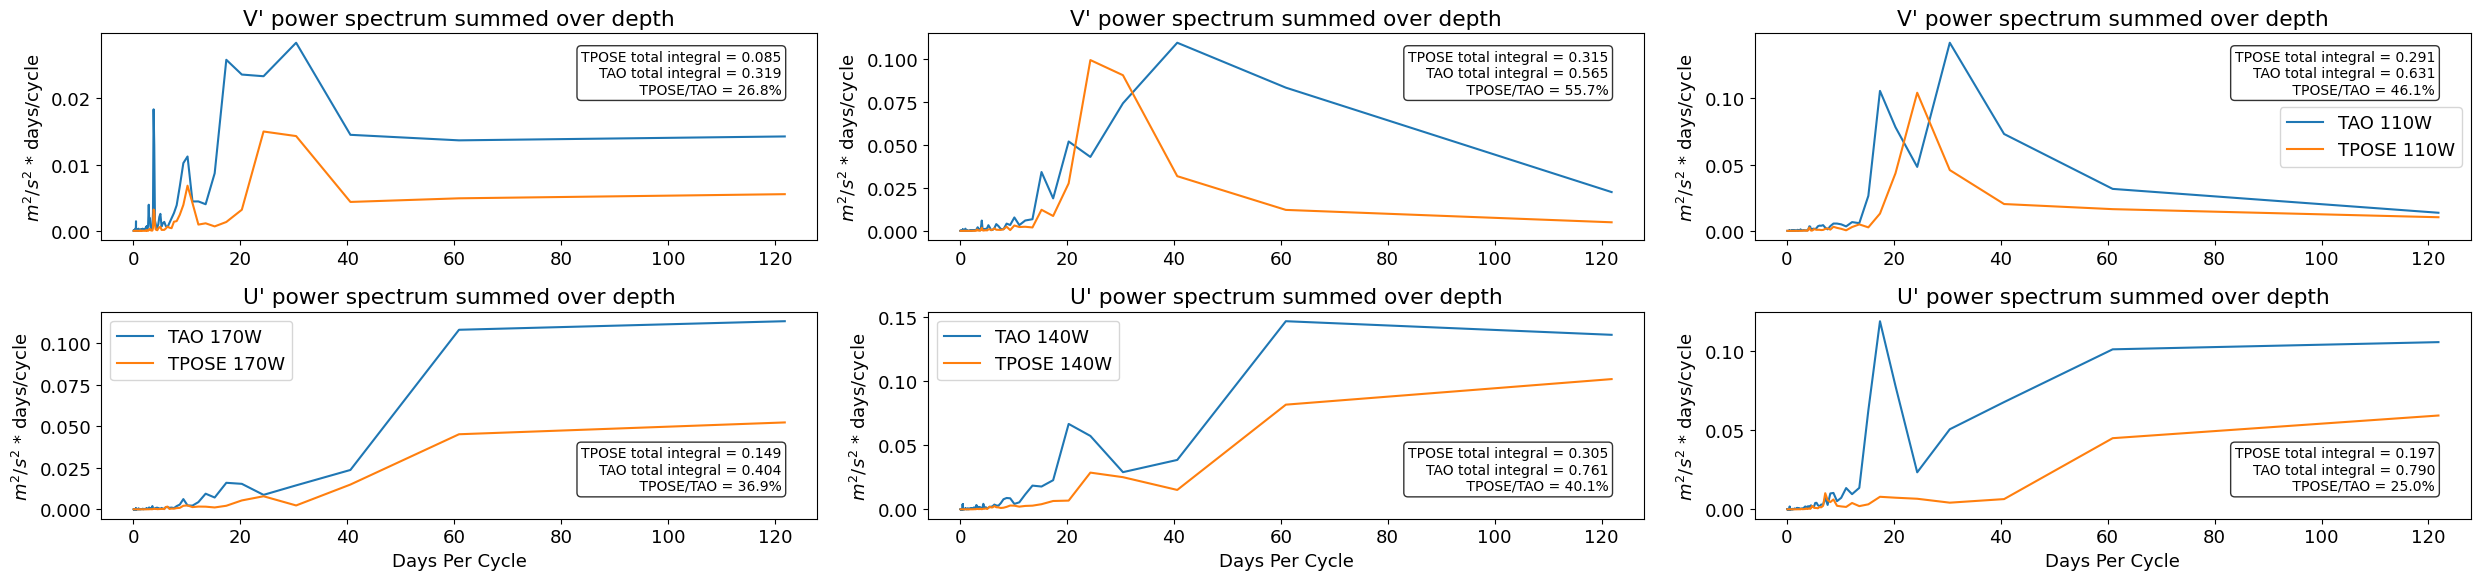

In [12]:
fig, ax = plt.subplots(figsize=(25,6),nrows=2, ncols=3)
ax[0,0].plot(vprime_tao_filt_170.time, vprime_tao_filt_170.sum(dim='Z'),label='TAO 170W')
ax[0,0].plot(vprime_tpose_filt_170.time, vprime_tpose_filt_170.sum(dim='Z'),label='TPOSE 170W')
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel(label_str)
ax[0,0].set_title('V\' power spectrum summed over depth')
# ax[0,0].legend()

textstr = f"TPOSE total integral = {v_tpose_total_170:.3f}\nTAO total integral = {v_tao_total_170:.3f}\n TPOSE/TAO = {(v_ratio_170*100):.1f}%"

# Add text box
ax[0,0].text(
    0.95, 0.92, textstr,
    transform=ax[0,0].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

ax[1,0].plot(uprime_tao_filt_170.time, uprime_tao_filt_170.sum(dim='Z'),label='TAO 170W')
ax[1,0].plot(uprime_tpose_filt_170.time, uprime_tpose_filt_170.sum(dim='Z'),label='TPOSE 170W')
ax[1,0].set_xlabel('Days Per Cycle')
ax[1,0].set_ylabel(label_str)
ax[1,0].set_title('U\' power spectrum summed over depth')
ax[1,0].legend()

textstr = f"TPOSE total integral = {u_tpose_total_170:.3f}\nTAO total integral = {u_tao_total_170:.3f}\n TPOSE/TAO = {(u_ratio_170*100):.1f}%"

# Add text box
ax[1,0].text(
    0.95, 0.35, textstr,
    transform=ax[1,0].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

ax[0,1].plot(vprime_tao_filt_140.time, vprime_tao_filt_140.sum(dim='Z'),label='TAO 140W')
ax[0,1].plot(vprime_tpose_filt_140.time, vprime_tpose_filt_140.sum(dim='Z'),label='TPOSE 140W')
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel(label_str)
ax[0,1].set_title('V\' power spectrum summed over depth')
# ax[0,1].legend()

textstr = f"TPOSE total integral = {v_tpose_total_140:.3f}\nTAO total integral = {v_tao_total_140:.3f}\n TPOSE/TAO = {(v_ratio_140*100):.1f}%"

# Add text box
ax[0,1].text(
    0.95, 0.92, textstr,
    transform=ax[0,1].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

ax[1,1].plot(uprime_tao_filt_140.time, uprime_tao_filt_140.sum(dim='Z'),label='TAO 140W')
ax[1,1].plot(uprime_tpose_filt_140.time, uprime_tpose_filt_140.sum(dim='Z'),label='TPOSE 140W')
ax[1,1].set_xlabel('Days Per Cycle')
ax[1,1].set_ylabel(label_str)
ax[1,1].set_title('U\' power spectrum summed over depth')
ax[1,1].legend()

textstr = f"TPOSE total integral = {u_tpose_total_140:.3f}\nTAO total integral = {u_tao_total_140:.3f}\n TPOSE/TAO = {(u_ratio_140*100):.1f}%"

# Add text box
ax[1,1].text(
    0.95, 0.35, textstr,
    transform=ax[1,1].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

ax[0,2].plot(vprime_tao_filt_110.time, vprime_tao_filt_110.sum(dim='Z'),label='TAO 110W')
ax[0,2].plot(vprime_tpose_filt_110.time, vprime_tpose_filt_110.sum(dim='Z'),label='TPOSE 110W')
ax[0,2].set_xlabel('')
ax[0,2].set_ylabel(label_str)
ax[0,2].set_title('V\' power spectrum summed over depth')
ax[0,2].legend()

textstr = f"TPOSE total integral = {v_tpose_total_110:.3f}\nTAO total integral = {v_tao_total_110:.3f}\n TPOSE/TAO = {(v_ratio_110*100):.1f}%"

# Add text box
ax[0,2].text(
    0.95, 0.92, textstr,
    transform=ax[0,2].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

ax[1,2].plot(uprime_tao_filt_110.time, uprime_tao_filt_110.sum(dim='Z'),label='TAO 110W')
ax[1,2].plot(uprime_tpose_filt_110.time, uprime_tpose_filt_110.sum(dim='Z'),label='TPOSE 110W')
ax[1,2].set_xlabel('Days Per Cycle')
ax[1,2].set_ylabel(label_str)
ax[1,2].set_title('U\' power spectrum summed over depth')
# ax[1,2].legend()

textstr = f"TPOSE total integral = {u_tpose_total_110:.3f}\nTAO total integral = {u_tao_total_110:.3f}\n TPOSE/TAO = {(u_ratio_110*100):.1f}%"

# Add text box
ax[1,2].text(
    0.95, 0.35, textstr,
    transform=ax[1,2].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

plt.tight_layout()
plt.savefig('Velocity_Power_Compare_TAO_iter0.png',format='png')

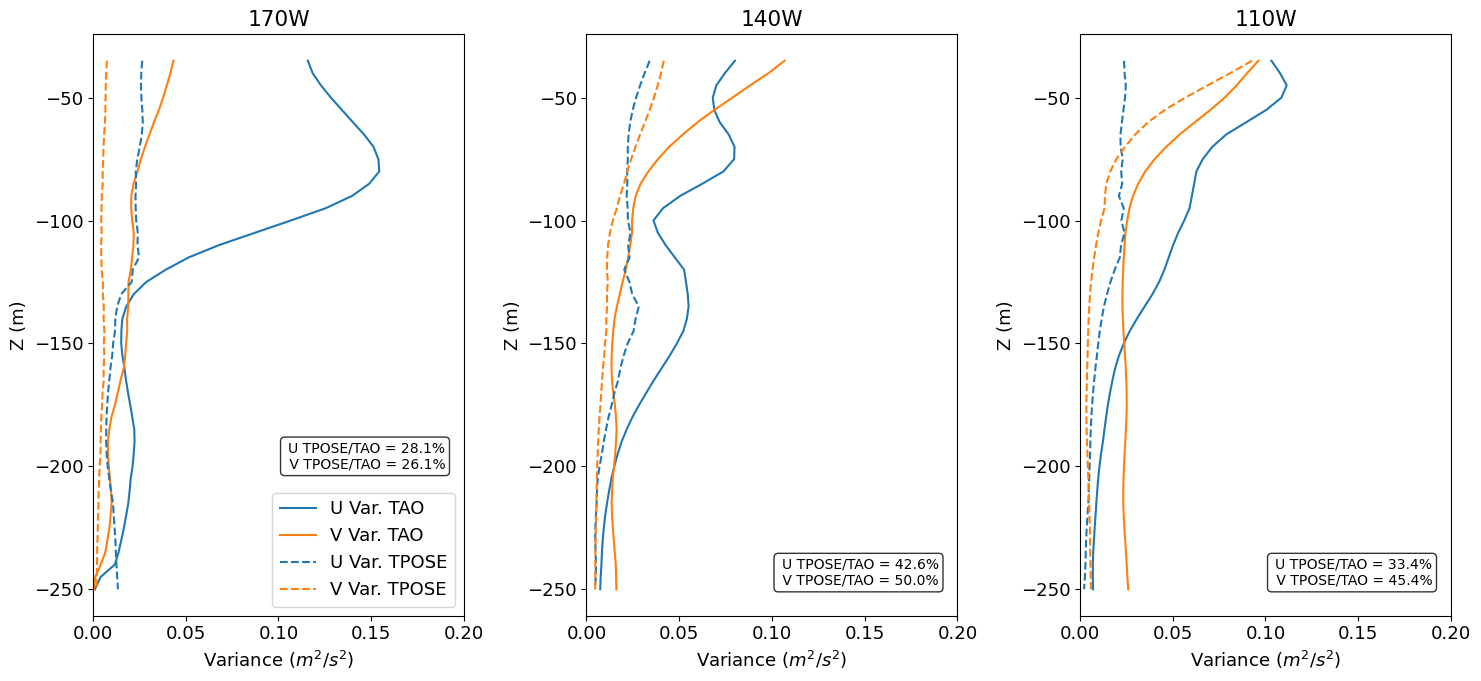

In [13]:

fig, ax = plt.subplots(figsize=(15, 7),ncols=3)
u_var_tao = U6_TAO_170.var(dim='time',skipna=True)
v_var_tao = V6_TAO_170.var(dim='time',skipna=True)
ax[0].plot(u_var_tao, U6_TAO_170.Z, color='tab:blue', label='U Var. TAO')
ax[0].plot(v_var_tao, V6_TAO_170.Z, color='tab:orange', label='V Var. TAO')
u_var_tpose = U6_170.var(dim='time',skipna=True)
v_var_tpose = V6_170.var(dim='time',skipna=True)
ax[0].plot(u_var_tpose, U6_170.Z, color='tab:blue', linestyle='--', label='U Var. TPOSE')
ax[0].plot(v_var_tpose, V6_170.Z, color='tab:orange', linestyle='--', label='V Var. TPOSE')
ax[0].legend(loc='lower right')
ax[0].set_title('170W')
ax[0].set_xlabel('Variance ($m^2/s^2$)') 
ax[0].set_ylabel('Z (m)')
ax[0].set_xlim(0.0, 0.2)

u_ratio_170 = (u_var_tpose.sum()/u_var_tao.sum()).values
v_ratio_170 = (v_var_tpose.sum()/v_var_tao.sum()).values

textstr = f"U TPOSE/TAO = {(u_ratio_170*100):.1f}%\n V TPOSE/TAO = {(v_ratio_170*100):.1f}%"

# Add text box
ax[0].text(
    0.95, 0.3, textstr,
    transform=ax[0].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

u_var_tao = U6_TAO_140.var(dim='time',skipna=True)
v_var_tao = V6_TAO_140.var(dim='time',skipna=True)
ax[1].plot(u_var_tao, U6_TAO_140.Z, color='tab:blue', label='U Var. TAO')
ax[1].plot(v_var_tao, V6_TAO_140.Z, color='tab:orange', label='V Var. TAO')
u_var_tpose = U6_140.var(dim='time',skipna=True)
v_var_tpose = V6_140.var(dim='time',skipna=True)
ax[1].plot(u_var_tpose, U6_140.Z, color='tab:blue', linestyle='--', label='U Var. TPOSE')
ax[1].plot(v_var_tpose, V6_140.Z, color='tab:orange', linestyle='--', label='V Var. TPOSE')
# ax[1].legend(loc='lower right')
ax[1].set_title('140W')
ax[1].set_xlim(0.0, 0.2)
ax[1].set_xlabel('Variance ($m^2/s^2$)') 
ax[1].set_ylabel('Z (m)')

u_ratio_140 = (u_var_tpose.sum()/u_var_tao.sum()).values
v_ratio_140 = (v_var_tpose.sum()/v_var_tao.sum()).values

textstr = f"U TPOSE/TAO = {(u_ratio_140*100):.1f}%\n V TPOSE/TAO = {(v_ratio_140*100):.1f}%"

# Add text box
ax[1].text(
    0.95, 0.1, textstr,
    transform=ax[1].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)


u_var_tao = U6_TAO_110.var(dim='time',skipna=True)
v_var_tao = V6_TAO_110.var(dim='time',skipna=True)
ax[2].plot(u_var_tao, U6_TAO_110.Z, color='tab:blue', label='U Var. TAO')
ax[2].plot(v_var_tao, V6_TAO_110.Z, color='tab:orange', label='V Var. TAO')
u_var_tpose = U6_110.var(dim='time',skipna=True)
v_var_tpose = V6_110.var(dim='time',skipna=True)
ax[2].plot(u_var_tpose, U6_110.Z, color='tab:blue', linestyle='--', label='U Var. TPOSE')
ax[2].plot(v_var_tpose, V6_110.Z, color='tab:orange', linestyle='--', label='V Var. TPOSE')
# ax[2].legend(loc='lower right')
ax[2].set_title('110W')
ax[2].set_xlim(0.0, 0.2)
ax[2].set_xlabel('Variance ($m^2/s^2$)') 
ax[2].set_ylabel('Z (m)')

u_ratio_110 = (u_var_tpose.sum()/u_var_tao.sum()).values
v_ratio_110 = (v_var_tpose.sum()/v_var_tao.sum()).values

textstr = f"U TPOSE/TAO = {(u_ratio_110*100):.1f}%\n V TPOSE/TAO = {(v_ratio_110*100):.1f}%"

# Add text box
ax[2].text(
    0.95, 0.1, textstr,
    transform=ax[2].transAxes,  # axes fraction
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

plt.tight_layout()
plt.savefig('ADCP_iter0_Var.png')

In [20]:
(uprime_tao_filt_140[-24:].sum()/uprime_tao_filt_140[:-24].sum()).values

array(0.00034655)

In [21]:
(vprime_tao_filt_140[-24:].sum()/vprime_tao_filt_140[:-24].sum()).values

array(0.00020444)

In [ ]:
client.shutdown()